# Gusto

Acute myocardial infarction (“heart attack”) is caused by the formation of a clot in one of the coronary arteries that supply blood to the heart muscle. 

Acute MI is a major public health problem. Mortality is substantial in the period immediately after the event (and also during the years after surviving the initial  infarction). Some patients die before reaching the  hospital. Patients seen in hospitals are reported to have an average mortality within 30 days around 6–15%, with improvement over time. The risk of 30-day mortality strongly depends on various prognostic factors. In younger patients, risks are much lower than in older patients. Other patient demographics are also important (gender, length, weight), as well as the presence of risk factors (hypertension, diabetes, smoking, family history) and the history of previous cardiovascular events (previous MI, angina, stroke, bypass surgery). Relevant presenting characteristics includethe location of the infarction and the extent of ECG abnormalities. Very important is the acute state of the patients reflected by blood pressure,heart rate, and left ventricular function (e.g., presence of shock).

Aim of this study is to find predictors of 30-days mortality. 

In [1]:
!pip install pandas matplotlib seaborn sklearn xgboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
##################################### IMPORTS ########################################

# general
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
from time import sleep

# data manipulation
import pandas as pd

#math
import numpy as np
from scipy.special import expit

# plot
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

# learn
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.base import BaseEstimator
from xgboost import XGBRegressor, XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

# interactive
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
#  load data
df = pd.read_csv("./Gusto.csv")

# dummify smk categories
df['eversmk']= (df['smk']!=1).astype(int)
df['currentsmk']=(df['smk']==3).astype(int)
df.drop(["smk"], axis=1, inplace=True)
df

,day30,sex,age,a65,killip,sho,dia,hyp,hrt,ant,...,wei,htn,lip,pan,fam,ste,st4,ttr,eversmk,currentsmk
0,0,0,70.313,1,1,0,0,0,0,1,...,84.0,1,1,0,0,1,0,1,1,1
1,0,0,59.844,0,1,0,1,0,0,1,...,115.0,1,0,0,1,6,1,0,0,0
2,0,0,59.023,0,1,0,0,0,1,0,...,76.0,1,0,0,1,3,0,0,0,0
3,1,1,80.375,1,1,0,0,0,1,0,...,50.0,0,0,0,0,3,0,0,1,1
4,0,0,64.750,0,1,0,0,1,0,0,...,97.4,0,0,1,1,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,0,0,51.836,0,1,0,0,0,0,1,...,65.0,0,0,0,0,7,1,1,0,0
3657,0,0,51.836,0,1,0,1,0,0,1,...,72.1,0,0,1,0,7,1,1,1,1
3658,0,0,63.977,0,1,0,0,0,0,0,...,87.2,1,0,0,0,2,0,1,1,0
3659,0,1,59.758,0,1,0,0,0,0,0,...,57.8,0,0,0,0,6,1,1,1,1


In [4]:
# any null value?
bool(df.isnull().sum().sum())

False

In [5]:
# dropping useless/redundant columns
df.drop(["sho", "a65", "st4"], axis=1, inplace=True)
df.columns

Index(['day30', 'sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk',
       'currentsmk'],
      dtype='object')

## Question 1

*Build a descriptive table, comparing patients deadversuspatients alive at 30 days. Insert also a column with the total population descriptive statistics.*




## Question 2

*Perform univariable logistic regression analyses, of all candidate predictors for your model. Optional:For Age is the linearity effect reasonable? How could you model alternatively the age effect?



In [6]:
# quick overview
print(df.describe())

             day30          sex          age       killip          dia  \
count  3661.000000  3661.000000  3661.000000  3661.000000  3661.000000   
mean      0.063098     0.256760    60.849984     1.157334     0.131385   
std       0.243171     0.436906    11.805047     0.432737     0.337867   
min       0.000000     0.000000    23.910000     1.000000     0.000000   
25%       0.000000     0.000000    51.547000     1.000000     0.000000   
50%       0.000000     0.000000    61.266000     1.000000     0.000000   
75%       0.000000     1.000000    70.094000     1.000000     0.000000   
max       1.000000     1.000000    89.484000     4.000000     1.000000   

               hyp          hrt          ant          pmi          hei  \
count  3661.000000  3661.000000  3661.000000  3661.000000  3661.000000   
mean      0.087135     0.317126     0.367932     0.168533   171.409314   
std       0.282071     0.465421     0.482309     0.374390    10.006255   
min       0.000000     0.000000     0

''

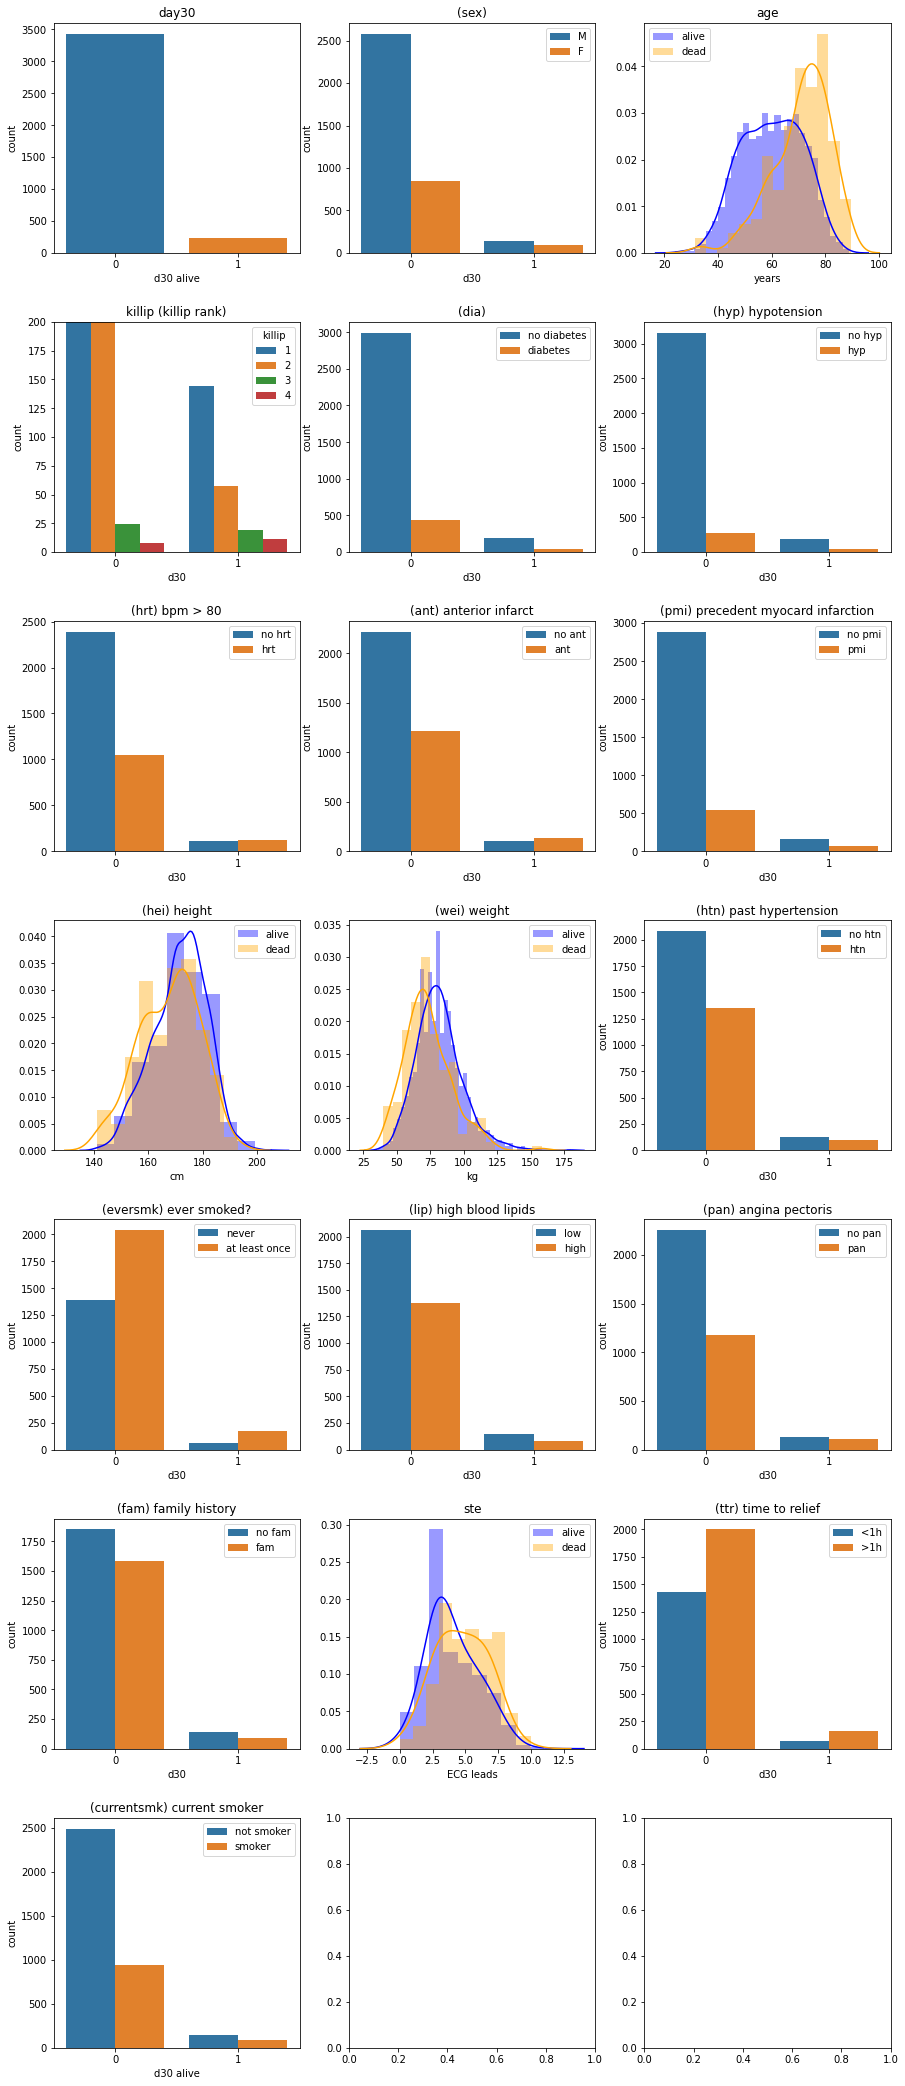

In [7]:
fig, ((a11,a12,a13),
      (a21,a22,a23), 
      (a31,a32,a33),
      (a41,a42,a43),
      (a51,a52,a53),
      (a61,a62,a63),
      (a71,_  ,_  ))= plt.subplots(7,3, figsize=(15,15))


var = "day30"
#a11.hist(df[var], bins=2)
sns.countplot(x='day30',data=df, ax=a11)
a11.set_title(var)
a11.set_xlabel("d30 alive")

sns.countplot(x='day30',hue='sex',data=df, ax=a12)
a12.set_title("(sex)")
a12.legend(["M","F"])
a12.set_xlabel("d30")

sns.distplot( df.loc[df.day30==0, 'age'] , color="blue", label="0", ax=a13)
sns.distplot( df.loc[df.day30==1, 'age'] , color="orange", label="1", ax=a13)
a13.set_title("age")
a13.set_xlabel("years")
a13.legend(["alive","dead"])

var = "killip"
a21.set_ylim([0,200])
sns.countplot(x='day30',hue='killip',data=df, ax=a21)
a21.set_title("killip (killip rank)")
a21.set_xlabel("d30")


sns.countplot(x='day30',hue='dia',data=df, ax=a22)
a22.set_title("(dia)")
a22.legend(["no diabetes","diabetes"])
a22.set_xlabel("d30")


sns.countplot(x='day30',hue='hyp',data=df, ax=a23)
a23.set_title("(hyp) hypotension")
a23.legend(["no hyp","hyp"])
a23.set_xlabel("d30")

sns.countplot(x='day30',hue='hrt',data=df, ax=a31)
a31.set_title("(hrt) bpm > 80")
a31.legend(["no hrt","hrt"])
a31.set_xlabel("d30")

sns.countplot(x='day30',hue='ant',data=df, ax=a32)
a32.set_title("(ant) anterior infarct")
a32.legend(["no ant","ant"])
a32.set_xlabel("d30")

sns.countplot(x='day30',hue='pmi',data=df, ax=a33)
a33.set_title("(pmi) precedent myocard infarction")
a33.legend(["no pmi","pmi"])
a33.set_xlabel("d30")

sns.distplot( df.loc[df.day30==0, 'hei'] , color="blue", label="0", ax=a41, bins=10)
sns.distplot( df.loc[df.day30==1, 'hei'] , color="orange", label="1", ax=a41, bins=10)
a41.set_title("(hei) height")
a41.legend(["alive","dead"])
a41.set_xlabel("cm")

sns.distplot( df.loc[df.day30==0, 'wei'] , color="blue", label="0", ax=a42)
sns.distplot( df.loc[df.day30==1, 'wei'] , color="orange", label="1", ax=a42)
a42.set_title("(wei) weight")
a42.legend(["alive","dead"])
a42.set_xlabel("kg")

sns.countplot(x='day30',hue='htn',data=df, ax=a43)
a43.set_title("(htn) past hypertension")
a43.legend(["no htn","htn"])
a43.set_xlabel("d30")

sns.countplot(x='day30',hue='eversmk',data=df, ax=a51)
a51.set_title("(eversmk) ever smoked?")
a51.legend(["never","at least once"])
a51.set_xlabel("d30")

sns.countplot(x='day30',hue='lip',data=df, ax=a52)
a52.set_title("(lip) high blood lipids")
a52.legend(["low","high"])
a52.set_xlabel("d30")

sns.countplot(x='day30',hue='pan',data=df, ax=a53)
a53.set_title("(pan) angina pectoris")
a53.legend(["no pan","pan"])
a53.set_xlabel("d30")

sns.countplot(x='day30',hue='fam',data=df, ax=a61)
a61.set_title("(fam) family history")
a61.legend(["no fam","fam"])
a61.set_xlabel("d30")

sns.distplot( df.loc[df.day30==0, 'ste'] , color="blue", label="0", ax=a62, kde_kws={"bw":1}, bins=10)
sns.distplot( df.loc[df.day30==1, 'ste'] , color="orange", label="1", ax=a62, kde_kws={"bw":1}, bins=10)
a62.set_title("ste")
a62.legend(["alive","dead"])
a62.set_xlabel("ECG leads")

sns.countplot(x='day30',hue='ttr',data=df, ax=a63)
a63.set_title("(ttr) time to relief")
a63.legend(["<1h",">1h"])
a63.set_xlabel("d30")

sns.countplot(x='day30',hue='currentsmk',data=df, ax=a71)
a71.set_title("(currentsmk) current smoker")
a71.set_xlabel("d30 alive")
a71.legend(["not smoker", "smoker"])


plt.subplots_adjust(wspace = 0.2, hspace=0.3, top=2)


""

## check for multicollinearity

''

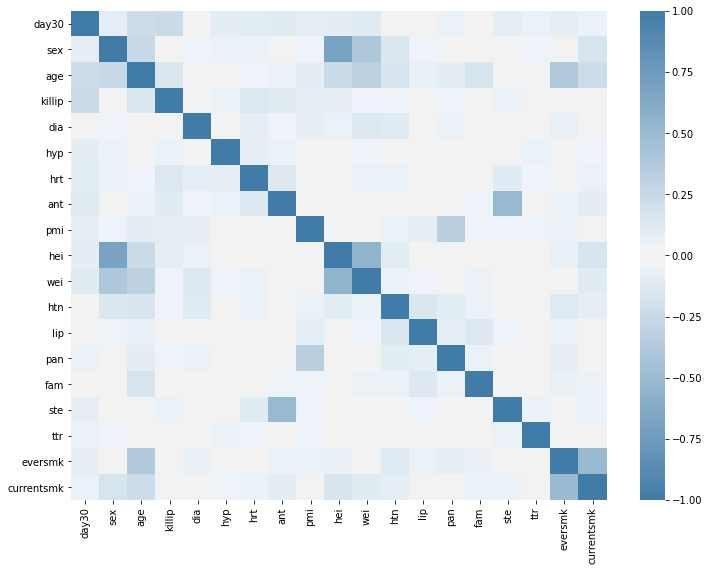

In [8]:
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(240, 240, n=256))
''

Analizzando la correlazione tra variabili, vediamo come alcune coppie di variabili siano correlate:

* `age <-> hei <-> sex <-> wei`  (prevedibilmente. valutare di unificarle?)
* `age <-> smoke`  (comprensibilmente)
* `currentsmoke <-> eversmoke` (è dura smettere)
* `age <-> sex`  (questa è da indagare)
* `ste <-> ant`  (anomalie ECG in caso di infarti precedenti?)
* `pan <-> pmi`  (angina e infarti al miocardio)

# Univariate logistic regressions

*Perform univariable logistic regressionanalyses, of all candidate predictors for your model. Optional:For Age is the linearity effect reasonable?How could you model alternativelythe age effect?*

In [9]:
# We'll now write a function to fit a logistic regressor and plot its predictions.

# Due to the problem in case of false negative, we've decided to include a weighting.
# In all computations, a false positive is a more severe error than a false negative.
# A good approximation is to use the inverse of the relative class frequency, or 
# n_samples / (n_classes * np.bincount(y)). The chosen value, 15, was derived from 
# a crude approximation of the relative frequency (~14).

weight=14 # times a false positive

def LR(candidates):
    
    # subset covariates and outcome
    X = df[candidates]
    y = df.day30
    # split data in 80% train / 20% test
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=0)    
    # instantiate a regressor
    logistic_regression= LogisticRegression(solver='lbfgs', class_weight={0:1,1:weight})
    # fit on data
    logistic_regression.fit(X_train,y_train)
    # predict
    y_pred=logistic_regression.predict(X_test)
    # compute confusion matrix
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(3, 2))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    # compute metrics
    precision, recall, F1score, support = tuple(metrics.precision_recall_fscore_support(y_test, y_pred))
    # print metrics    
    print('Precision-> vivi:{:.4} morti:{:.4}, \nRecall->    vivi:{:.4} morti:{:.4}, \
          \nF1-Score->  vivi:{:.4} morti:{:.4}, \nSupport->   vivi:{}   morti:{} \n\n'.format(precision[0], precision[1], 
                                                                                         recall[0], recall[1], 
                                                                                         F1score[0], F1score[1], 
                                                                                         support[0], support[1]))    
    #show plot
    plt.show()
    return logistic_regression, X, y, 

# plot logistic regression 
def LRplot(lr, xmi, xma):
    
    #if lr.coef_.shape!=(1,1): return
    
    Xi = np.linspace(xmi,xma,10)
    yi = lr.predict(Xi[:, np.newaxis])
    ypi = lr.predict_proba(Xi[:, np.newaxis])[:,1]
    print(Xi.astype(list),ypi.astype(list))
    # double scatterplot of prediction ad prediction probabilities    
    sns.scatterplot(Xi.astype(list),yi.astype(list))
    sns.scatterplot(list(Xi), list(ypi))
    



 ##############################    sex    ############################## 

Precision-> vivi:0.9436 morti:0.1056, 
Recall->    vivi:0.7517 morti:0.3947,           
F1-Score->  vivi:0.8368 morti:0.1667, 
Support->   vivi:1023   morti:76 




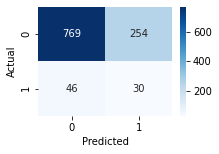

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    age    ############################## 

Precision-> vivi:0.9651 morti:0.1416, 
Recall->    vivi:0.7038 morti:0.6579,           
F1-Score->  vivi:0.814 morti:0.2331, 
Support->   vivi:1023   morti:76 




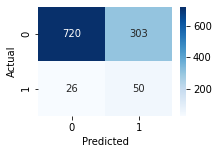

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    killip    ############################## 

Precision-> vivi:0.9501 morti:0.1835, 
Recall->    vivi:0.8739 morti:0.3816,           
F1-Score->  vivi:0.9104 morti:0.2479, 
Support->   vivi:1023   morti:76 




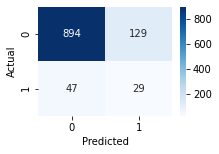

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    dia    ############################## 

Precision-> vivi:0.9359 morti:0.1014, 
Recall->    vivi:0.87 morti:0.1974,           
F1-Score->  vivi:0.9017 morti:0.1339, 
Support->   vivi:1023   morti:76 




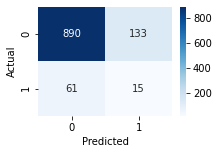

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    hyp    ############################## 

Precision-> vivi:0.9372 morti:0.1354, 
Recall->    vivi:0.9189 morti:0.1711,           
F1-Score->  vivi:0.9279 morti:0.1512, 
Support->   vivi:1023   morti:76 




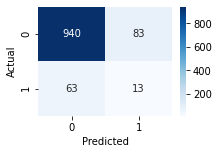

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    hrt    ############################## 

Precision-> vivi:0.938 morti:0.08615, 
Recall->    vivi:0.7097 morti:0.3684,           
F1-Score->  vivi:0.808 morti:0.1397, 
Support->   vivi:1023   morti:76 




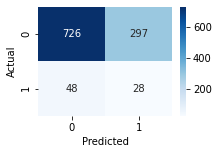

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    ant    ############################## 

Precision-> vivi:0.9519 morti:0.1105, 
Recall->    vivi:0.6774 morti:0.5395,           
F1-Score->  vivi:0.7915 morti:0.1834, 
Support->   vivi:1023   morti:76 




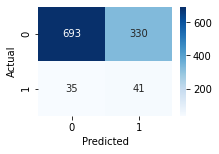

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    pmi    ############################## 

Precision-> vivi:0.9363 morti:0.09574, 
Recall->    vivi:0.8338 morti:0.2368,           
F1-Score->  vivi:0.8821 morti:0.1364, 
Support->   vivi:1023   morti:76 




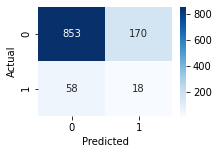

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    hei    ############################## 

Precision-> vivi:0.9431 morti:0.09621, 
Recall->    vivi:0.697 morti:0.4342,           
F1-Score->  vivi:0.8016 morti:0.1575, 
Support->   vivi:1023   morti:76 




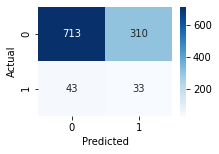

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    wei    ############################## 

Precision-> vivi:0.9559 morti:0.1229, 
Recall->    vivi:0.6999 morti:0.5658,           
F1-Score->  vivi:0.8081 morti:0.2019, 
Support->   vivi:1023   morti:76 




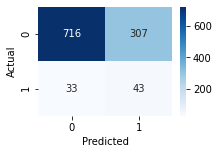

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    htn    ############################## 

Precision-> vivi:0.93 morti:0.06809, 
Recall->    vivi:0.5718 morti:0.4211,           
F1-Score->  vivi:0.7082 morti:0.1172, 
Support->   vivi:1023   morti:76 




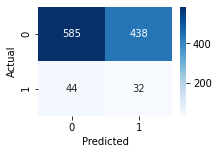

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    lip    ############################## 

Precision-> vivi:0.9308 morti:0.0, 
Recall->    vivi:1.0 morti:0.0,           
F1-Score->  vivi:0.9642 morti:0.0, 
Support->   vivi:1023   morti:76 




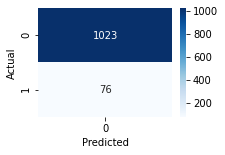

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    pan    ############################## 

Precision-> vivi:0.9441 morti:0.09227, 
Recall->    vivi:0.6442 morti:0.4868,           
F1-Score->  vivi:0.7658 morti:0.1551, 
Support->   vivi:1023   morti:76 




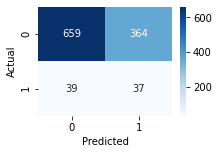

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    fam    ############################## 

Precision-> vivi:0.9308 morti:0.0, 
Recall->    vivi:1.0 morti:0.0,           
F1-Score->  vivi:0.9642 morti:0.0, 
Support->   vivi:1023   morti:76 




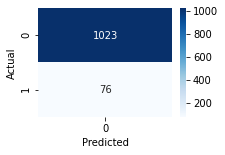

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    ste    ############################## 

Precision-> vivi:0.9534 morti:0.11, 
Recall->    vivi:0.6598 morti:0.5658,           
F1-Score->  vivi:0.7799 morti:0.1842, 
Support->   vivi:1023   morti:76 




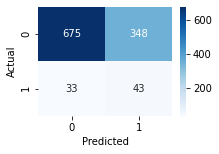

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    ttr    ############################## 

Precision-> vivi:0.9451 morti:0.08, 
Recall->    vivi:0.4379 morti:0.6579,           
F1-Score->  vivi:0.5985 morti:0.1427, 
Support->   vivi:1023   morti:76 




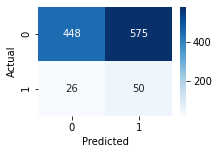

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    eversmk    ############################## 

Precision-> vivi:0.9523 morti:0.08464, 
Recall->    vivi:0.4291 morti:0.7105,           
F1-Score->  vivi:0.5916 morti:0.1513, 
Support->   vivi:1023   morti:76 




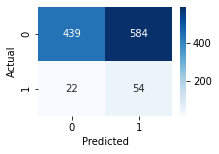

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    currentsmk    ############################## 

Precision-> vivi:0.9388 morti:0.08889, 
Recall->    vivi:0.7195 morti:0.3684,           
F1-Score->  vivi:0.8146 morti:0.1432, 
Support->   vivi:1023   morti:76 




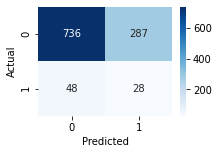

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [10]:
#for col in df.columns[1:]:
for col in ['sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk','currentsmk']:
    print("\n\n","#"*30,"  " ,str(col), "  ","#"*30,"\n")
    lr, X, y = LR([str(col)])
    print(lr)
    

## Question 3

*Build  a multivariable  logistic  regression model  starting from the list of significant predictors at univariable analyses. Pay attention to multicollinearity (same variables recoded in different ways).* 



Precision-> vivi:0.9643 morti:0.1783, 
Recall->    vivi:0.7928 morti:0.6053,           
F1-Score->  vivi:0.8702 morti:0.2754, 
Support->   vivi:1023   morti:76 




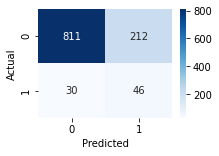

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
coefficients =
[('sex', -0.4786588275544941),
 ('age', 0.08716083694818433),
 ('killip', 0.7897648590906772),
 ('dia', -0.08945303043630952),
 ('hyp', 1.2485165047641766),
 ('hrt', 0.9067838102933198),
 ('ant', 0.42676020447279245),
 ('pmi', 0.667272219941238),
 ('hei', -0.04167562762894947),
 ('wei', -0.011187879666647553),
 ('htn', 0.17768066068370322),
 ('lip', 0.11641765597038788),
 ('pan', 0.00483801993996467),
 ('fam', 0.040765793262937736),
 ('ste', 0.12179812380692495),
 ('ttr', 0.3541058931853356),
 ('eversmk', -0.26520292419916613),
 ('currentsmk', 0.07205055468945085)]
'intercept: [-0.47221583]'


In [11]:
# full model

covar = ['sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn',  'lip', 'pan', 'fam', 'ste', 'ttr','eversmk','currentsmk']

fullModel, X1, y1 = LR(covar)
print(fullModel)

print("coefficients =")
pprint(list(zip(covar,fullModel.coef_.tolist()[0])))
pprint("intercept: {}".format(fullModel.intercept_))


# removing multicollinear variables

* `age <-> hei <-> sex <-> wei`  (prevedibilmente)
* `age <-> smoke`  (comprensibilmente)
* `age <-> sex`  (questa è da indagare)
* `ste <-> ant`  (anomalie ECG in caso di infarti precedenti?)
* `pan <-> pmi`  (angina e infarti al miocardio)



* Removing: `'hei','wei','age'`, leaving `'sex'` and `'smoke'`
* Removing: `'pan'`, leaving `'pmi'`
* Removing: `'ste'`, leaving `'ant'`

Precision-> vivi:0.9575 morti:0.1594, 
Recall->    vivi:0.7937 morti:0.5263,           
F1-Score->  vivi:0.868 morti:0.2446, 
Support->   vivi:1023   morti:76 




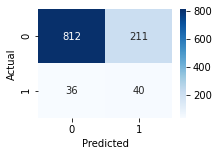

LogisticRegression(C=1.0, class_weight={0: 1, 1: 14}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
coefficients =
[('sex', 0.7846495661387441),
 ('killip', 0.9058119177378808),
 ('hyp', 1.1026013068507365),
 ('hrt', 0.3320866414259006),
 ('pmi', 0.8058738736567633),
 ('ttr', 0.3678344518904467),
 ('ant', 0.7439043660438006),
 ('dia', -0.22552537359964153),
 ('hrt', 0.3320866414259006),
 ('fam', -0.3561187350435934),
 ('htn', 0.19780735714707792),
 ('lip', -0.29668913037882416),
 ('eversmk', 0.5737425830094606),
 ('currentsmk', 0.03857173240020138)]
'intercept: [-2.92699962]'


In [12]:
# pruned model
covar = ['sex', 'killip', 'hyp', 'hrt', 'pmi',  
         'ttr','ant','dia', 'hrt', 'fam', 'htn', 
         'lip', 'eversmk', 'currentsmk']

prunedModel, X2, y2 = LR(covar)
print(prunedModel)


print("coefficients =")
pprint(list(zip(covar,prunedModel.coef_.tolist()[0])))
pprint("intercept: {}".format(prunedModel.intercept_))

## Question 4 

*Evaluate model performance in discrimination by means of the AUC under the ROC curve. Evaluate also model performance in terms of calibration.* 



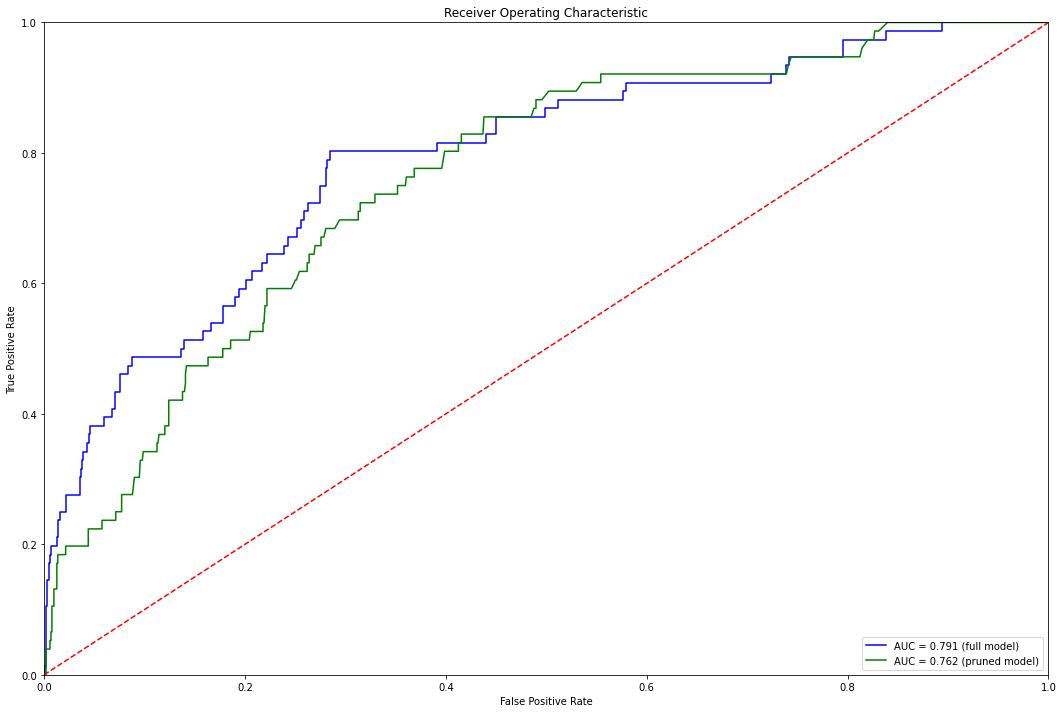

In [13]:

#split data in 80% train / 20% test
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.30,random_state=0)
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size=0.30,random_state=0)

# calculate the fpr and tpr for all thresholds of the classification
full_probs = fullModel.predict_proba(X1_test)
pruned_probs = prunedModel.predict_proba(X2_test)

full_preds = full_probs[:,1]
pruned_preds = pruned_probs[:,1]


fpr1, tpr1, threshold1 = metrics.roc_curve(y1_test, full_preds)
fpr2, tpr2, threshold2 = metrics.roc_curve(y2_test, pruned_preds)

roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)




import matplotlib.pyplot as plt

plt.figure(figsize=(18,12))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.3f (full model)' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.3f (pruned model)' % roc_auc2)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

font = {'weight' : 'bold',
        'size'   : 48}

matplotlib.rc('font', **font)

plt.show()


## Question 5

*Represent the estimated model by means of a nomogram (hint: R function nomogram {rms})*

Niente nomogrammi su python, però abbiamo fatto un widget interattivo.

Precision-> vivi:0.9656 morti:0.1836, 
Recall->    vivi:0.7957 morti:0.6184,           
F1-Score->  vivi:0.8725 morti:0.2831, 
Support->   vivi:1023   morti:76 




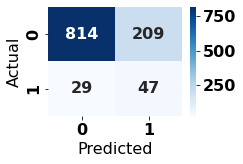

In [14]:
# pruned model
covar = ['sex', 'killip', 'age', 'hyp', 'hrt', 'pmi',  
         'ttr','ant','dia', 'fam', 'htn', 'lip', 'eversmk', 'currentsmk']

font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

lr, X, y = LR(covar)

In [15]:
print("             INTERACTIVE NOMOGRAM")
@interact(sex=["M","F"],   # sex
          killipClass=(1,4,1),  # killip
          age=(0,120,1), # age
          hypotension=False, # hyp
          tachycardia=False, # hrt
          previousMiocardialInfarction=False, # pmi          
          chestPainReliefTimeMoreThan1H=False, # ttr
          anteriorInfarctLocation=False, # ant
          diabetic=False, # dia
          familyHistoryOfMI=False, # fam
          hypertensionHistory=False, # htn
          hypercholesterilemia=False,
          everSmoke=False,
          currentSmoker=False) # lip
def pred(sex,killipClass,age,hypotension,tachycardia,previousMiocardialInfarction,
          chestPainReliefTimeMoreThan1H,anteriorInfarctLocation,diabetic,familyHistoryOfMI, 
          hypertensionHistory,hypercholesterilemia, everSmoke, currentSmoker):
    
    sex= 1 if sex == 'F' else 0
    
    covariates = np.array([sex,killipClass,age,hypotension,tachycardia,previousMiocardialInfarction, 
          chestPainReliefTimeMoreThan1H,anteriorInfarctLocation,diabetic,familyHistoryOfMI, 
          hypertensionHistory,hypercholesterilemia, everSmoke,currentSmoker])
    
    prediction = lr.predict([covariates.astype(int)]), 
    prob =       lr.predict_proba([covariates.astype(int)])

  
    #print("covariates:", covariates)
    print("p(morte)= {:.3}%".format(prob[0][1]*100))
    return



             INTERACTIVE NOMOGRAM


interactive(children=(Dropdown(description='sex', options=('M', 'F'), value='M'), IntSlider(value=2, descripti…

## Question 6

6) Internally validate the estimated model (hint: R function  validate {rms})



In [16]:
X = df[['sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk',
       'currentsmk']]
y = df[['day30']]

In [17]:
#@interact(metric = metrics.SCORERS.keys())

def test(metric):
    clf = LogisticRegressionCV(cv=10, random_state=0, scoring = metric).fit(X, y)
    print("metric: {}, score = {:.4}".format(metric,clf.score(X, y)))

## Question 7

*Setting  aside  the  interpretability  of  the  model, are  you  able  to  find  a  machine learning algorithm that predicts the risk of event with a similar (or better) performance than the logistic model*

In [18]:
class XGBoostWithEarlyStop(BaseEstimator):
    def __init__(self, early_stopping_rounds=5, test_size=0.1, 
                 eval_metric='mae', **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric='mae'        
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [19]:
x = df[['sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk',
       'currentsmk']]
y = df[['day30']]

print(x.shape, y.shape)

(3661, 18) (3661, 1)


In [20]:
# This block of code performs a grid search for the best 
# hyperparameters of PCA and XGBoost at the same time.
# Warning, this code is slow when run on myBinder (~15 min).
# final results indicates that 9 principal components and 70 XGBoost
# estimators are the optimal choice.

pipe = Pipeline([
    ('pca', PCA(5)),
    ('xgb', XGBoostRegressorWithEarlyStop())
])

param_grid = {
    'pca__n_components': [3, 5, 7, 9, 11, 13, 15],
    'xgb__n_estimators': [50, 70, 90, 110, 130]
}

grid = GridSearchCV(pipe, param_grid, scoring='neg_mean_absolute_error')
grid.fit(x, y)
print(grid.best_params_)

[0]	validation_0-mae:0.38287
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29876
[2]	validation_0-mae:0.24207
[3]	validation_0-mae:0.20081
[4]	validation_0-mae:0.17200
[5]	validation_0-mae:0.14993
[6]	validation_0-mae:0.13471
[7]	validation_0-mae:0.12416
[8]	validation_0-mae:0.11678
[9]	validation_0-mae:0.11248
[10]	validation_0-mae:0.10996
[11]	validation_0-mae:0.10798
[12]	validation_0-mae:0.10586
[13]	validation_0-mae:0.10477
[14]	validation_0-mae:0.10366
[15]	validation_0-mae:0.10302
[16]	validation_0-mae:0.10318
[17]	validation_0-mae:0.10161
[18]	validation_0-mae:0.10193
[19]	validation_0-mae:0.10155
[20]	validation_0-mae:0.10085
[21]	validation_0-mae:0.10029
[22]	validation_0-mae:0.09960
[23]	validation_0-mae:0.09865
[24]	validation_0-mae:0.09744
[25]	validation_0-mae:0.09683
[26]	validation_0-mae:0.09704
[27]	validation_0-mae:0.09688
[28]	validation_0-mae:0.09691
[29]	validation_0-mae:0.09664
[30]	validation_0-mae:0.09647
[31]	validation_0

[5]	validation_0-mae:0.15429
[6]	validation_0-mae:0.13899
[7]	validation_0-mae:0.12799
[8]	validation_0-mae:0.12134
[9]	validation_0-mae:0.11702
[10]	validation_0-mae:0.11350
[11]	validation_0-mae:0.11097
[12]	validation_0-mae:0.10909
[13]	validation_0-mae:0.10753
[14]	validation_0-mae:0.10700
[15]	validation_0-mae:0.10536
[16]	validation_0-mae:0.10475
[17]	validation_0-mae:0.10455
[18]	validation_0-mae:0.10349
[19]	validation_0-mae:0.10441
[20]	validation_0-mae:0.10433
[21]	validation_0-mae:0.10324
[22]	validation_0-mae:0.10278
[23]	validation_0-mae:0.10315
[24]	validation_0-mae:0.10317
[25]	validation_0-mae:0.10302
[26]	validation_0-mae:0.10316
[27]	validation_0-mae:0.10337
Stopping. Best iteration:
[22]	validation_0-mae:0.10278

[0]	validation_0-mae:0.37844
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29361
[2]	validation_0-mae:0.23360
[3]	validation_0-mae:0.19311
[4]	validation_0-mae:0.16408
[5]	validation_0-mae:0.14367
[6]	validation_0-mae:

[43]	validation_0-mae:0.09346
[44]	validation_0-mae:0.09332
[45]	validation_0-mae:0.09234
[46]	validation_0-mae:0.09227
[47]	validation_0-mae:0.09270
[48]	validation_0-mae:0.09286
[49]	validation_0-mae:0.09288
[50]	validation_0-mae:0.09284
[51]	validation_0-mae:0.09269
Stopping. Best iteration:
[46]	validation_0-mae:0.09227

[0]	validation_0-mae:0.38514
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.30363
[2]	validation_0-mae:0.24680
[3]	validation_0-mae:0.20586
[4]	validation_0-mae:0.17948
[5]	validation_0-mae:0.15912
[6]	validation_0-mae:0.14593
[7]	validation_0-mae:0.13661
[8]	validation_0-mae:0.12901
[9]	validation_0-mae:0.12321
[10]	validation_0-mae:0.12066
[11]	validation_0-mae:0.11924
[12]	validation_0-mae:0.11665
[13]	validation_0-mae:0.11557
[14]	validation_0-mae:0.11391
[15]	validation_0-mae:0.11368
[16]	validation_0-mae:0.11301
[17]	validation_0-mae:0.11268
[18]	validation_0-mae:0.11145
[19]	validation_0-mae:0.11111
[20]	validation_0-ma

[1]	validation_0-mae:0.29751
[2]	validation_0-mae:0.23912
[3]	validation_0-mae:0.19772
[4]	validation_0-mae:0.16835
[5]	validation_0-mae:0.14884
[6]	validation_0-mae:0.13451
[7]	validation_0-mae:0.12405
[8]	validation_0-mae:0.11645
[9]	validation_0-mae:0.11173
[10]	validation_0-mae:0.10761
[11]	validation_0-mae:0.10490
[12]	validation_0-mae:0.10251
[13]	validation_0-mae:0.10254
[14]	validation_0-mae:0.10197
[15]	validation_0-mae:0.10071
[16]	validation_0-mae:0.10040
[17]	validation_0-mae:0.09890
[18]	validation_0-mae:0.09935
[19]	validation_0-mae:0.09818
[20]	validation_0-mae:0.09829
[21]	validation_0-mae:0.09781
[22]	validation_0-mae:0.09817
[23]	validation_0-mae:0.09918
[24]	validation_0-mae:0.09797
[25]	validation_0-mae:0.09698
[26]	validation_0-mae:0.09724
[27]	validation_0-mae:0.09753
[28]	validation_0-mae:0.09735
[29]	validation_0-mae:0.09785
[30]	validation_0-mae:0.09788
Stopping. Best iteration:
[25]	validation_0-mae:0.09698

[0]	validation_0-mae:0.38364
Will train until valida

[1]	validation_0-mae:0.28489
[2]	validation_0-mae:0.22297
[3]	validation_0-mae:0.17882
[4]	validation_0-mae:0.14871
[5]	validation_0-mae:0.12650
[6]	validation_0-mae:0.10932
[7]	validation_0-mae:0.09811
[8]	validation_0-mae:0.09159
[9]	validation_0-mae:0.08654
[10]	validation_0-mae:0.08326
[11]	validation_0-mae:0.08062
[12]	validation_0-mae:0.07872
[13]	validation_0-mae:0.07710
[14]	validation_0-mae:0.07610
[15]	validation_0-mae:0.07727
[16]	validation_0-mae:0.07672
[17]	validation_0-mae:0.07542
[18]	validation_0-mae:0.07465
[19]	validation_0-mae:0.07440
[20]	validation_0-mae:0.07410
[21]	validation_0-mae:0.07443
[22]	validation_0-mae:0.07319
[23]	validation_0-mae:0.07339
[24]	validation_0-mae:0.07322
[25]	validation_0-mae:0.07299
[26]	validation_0-mae:0.07297
[27]	validation_0-mae:0.07332
[28]	validation_0-mae:0.07367
[29]	validation_0-mae:0.07379
[30]	validation_0-mae:0.07323
[31]	validation_0-mae:0.07411
Stopping. Best iteration:
[26]	validation_0-mae:0.07297

[0]	validation_0-mae:0

[3]	validation_0-mae:0.19377
[4]	validation_0-mae:0.16524
[5]	validation_0-mae:0.14417
[6]	validation_0-mae:0.12822
[7]	validation_0-mae:0.11764
[8]	validation_0-mae:0.10984
[9]	validation_0-mae:0.10411
[10]	validation_0-mae:0.10045
[11]	validation_0-mae:0.09763
[12]	validation_0-mae:0.09486
[13]	validation_0-mae:0.09341
[14]	validation_0-mae:0.09308
[15]	validation_0-mae:0.09249
[16]	validation_0-mae:0.09114
[17]	validation_0-mae:0.09064
[18]	validation_0-mae:0.09003
[19]	validation_0-mae:0.09162
[20]	validation_0-mae:0.09101
[21]	validation_0-mae:0.09020
[22]	validation_0-mae:0.08984
[23]	validation_0-mae:0.08898
[24]	validation_0-mae:0.08872
[25]	validation_0-mae:0.08839
[26]	validation_0-mae:0.08863
[27]	validation_0-mae:0.08867
[28]	validation_0-mae:0.08797
[29]	validation_0-mae:0.08793
[30]	validation_0-mae:0.08844
[31]	validation_0-mae:0.08856
[32]	validation_0-mae:0.08868
[33]	validation_0-mae:0.08865
[34]	validation_0-mae:0.08793
Stopping. Best iteration:
[29]	validation_0-mae

[8]	validation_0-mae:0.10512
[9]	validation_0-mae:0.09979
[10]	validation_0-mae:0.09415
[11]	validation_0-mae:0.09043
[12]	validation_0-mae:0.08887
[13]	validation_0-mae:0.08695
[14]	validation_0-mae:0.08660
[15]	validation_0-mae:0.08472
[16]	validation_0-mae:0.08423
[17]	validation_0-mae:0.08396
[18]	validation_0-mae:0.08293
[19]	validation_0-mae:0.08220
[20]	validation_0-mae:0.08213
[21]	validation_0-mae:0.08171
[22]	validation_0-mae:0.08185
[23]	validation_0-mae:0.08118
[24]	validation_0-mae:0.08176
[25]	validation_0-mae:0.08226
[26]	validation_0-mae:0.08293
[27]	validation_0-mae:0.08202
[28]	validation_0-mae:0.08198
Stopping. Best iteration:
[23]	validation_0-mae:0.08118

[0]	validation_0-mae:0.38112
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29912
[2]	validation_0-mae:0.24122
[3]	validation_0-mae:0.19858
[4]	validation_0-mae:0.17031
[5]	validation_0-mae:0.15039
[6]	validation_0-mae:0.13574
[7]	validation_0-mae:0.12417
[8]	validation_0-mae

[18]	validation_0-mae:0.08880
[19]	validation_0-mae:0.08810
[20]	validation_0-mae:0.08755
[21]	validation_0-mae:0.08763
[22]	validation_0-mae:0.08742
[23]	validation_0-mae:0.08695
[24]	validation_0-mae:0.08667
[25]	validation_0-mae:0.08668
[26]	validation_0-mae:0.08654
[27]	validation_0-mae:0.08683
[28]	validation_0-mae:0.08656
[29]	validation_0-mae:0.08694
[30]	validation_0-mae:0.08663
[31]	validation_0-mae:0.08675
Stopping. Best iteration:
[26]	validation_0-mae:0.08654

[0]	validation_0-mae:0.38330
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29905
[2]	validation_0-mae:0.24044
[3]	validation_0-mae:0.19736
[4]	validation_0-mae:0.16687
[5]	validation_0-mae:0.14340
[6]	validation_0-mae:0.12872
[7]	validation_0-mae:0.11754
[8]	validation_0-mae:0.10989
[9]	validation_0-mae:0.10272
[10]	validation_0-mae:0.09906
[11]	validation_0-mae:0.09522
[12]	validation_0-mae:0.09344
[13]	validation_0-mae:0.09192
[14]	validation_0-mae:0.09114
[15]	validation_0-ma

[9]	validation_0-mae:0.10877
[10]	validation_0-mae:0.10564
[11]	validation_0-mae:0.10218
[12]	validation_0-mae:0.10073
[13]	validation_0-mae:0.10005
[14]	validation_0-mae:0.09991
[15]	validation_0-mae:0.09899
[16]	validation_0-mae:0.09891
[17]	validation_0-mae:0.09954
[18]	validation_0-mae:0.10006
[19]	validation_0-mae:0.10060
[20]	validation_0-mae:0.10030
[21]	validation_0-mae:0.10074
Stopping. Best iteration:
[16]	validation_0-mae:0.09891

[0]	validation_0-mae:0.38231
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.30126
[2]	validation_0-mae:0.24168
[3]	validation_0-mae:0.20234
[4]	validation_0-mae:0.17343
[5]	validation_0-mae:0.15268
[6]	validation_0-mae:0.14032
[7]	validation_0-mae:0.12865
[8]	validation_0-mae:0.12131
[9]	validation_0-mae:0.11626
[10]	validation_0-mae:0.11242
[11]	validation_0-mae:0.11019
[12]	validation_0-mae:0.10776
[13]	validation_0-mae:0.10719
[14]	validation_0-mae:0.10667
[15]	validation_0-mae:0.10640
[16]	validation_0-mae

[0]	validation_0-mae:0.37925
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29634
[2]	validation_0-mae:0.23542
[3]	validation_0-mae:0.19243
[4]	validation_0-mae:0.16180
[5]	validation_0-mae:0.14039
[6]	validation_0-mae:0.12278
[7]	validation_0-mae:0.11115
[8]	validation_0-mae:0.10422
[9]	validation_0-mae:0.09913
[10]	validation_0-mae:0.09577
[11]	validation_0-mae:0.09374
[12]	validation_0-mae:0.09196
[13]	validation_0-mae:0.08994
[14]	validation_0-mae:0.08998
[15]	validation_0-mae:0.08963
[16]	validation_0-mae:0.08995
[17]	validation_0-mae:0.08910
[18]	validation_0-mae:0.08887
[19]	validation_0-mae:0.08979
[20]	validation_0-mae:0.08837
[21]	validation_0-mae:0.08796
[22]	validation_0-mae:0.08836
[23]	validation_0-mae:0.08855
[24]	validation_0-mae:0.08955
[25]	validation_0-mae:0.08941
[26]	validation_0-mae:0.08863
Stopping. Best iteration:
[21]	validation_0-mae:0.08796

[0]	validation_0-mae:0.38359
Will train until validation_0-mae hasn't improved i

[27]	validation_0-mae:0.09568
[28]	validation_0-mae:0.09492
[29]	validation_0-mae:0.09506
[30]	validation_0-mae:0.09512
[31]	validation_0-mae:0.09554
[32]	validation_0-mae:0.09582
[33]	validation_0-mae:0.09548
Stopping. Best iteration:
[28]	validation_0-mae:0.09492

[0]	validation_0-mae:0.38211
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29763
[2]	validation_0-mae:0.23666
[3]	validation_0-mae:0.19699
[4]	validation_0-mae:0.16590
[5]	validation_0-mae:0.14479
[6]	validation_0-mae:0.12990
[7]	validation_0-mae:0.11914
[8]	validation_0-mae:0.11163
[9]	validation_0-mae:0.10598
[10]	validation_0-mae:0.10318
[11]	validation_0-mae:0.10100
[12]	validation_0-mae:0.09948
[13]	validation_0-mae:0.09836
[14]	validation_0-mae:0.09767
[15]	validation_0-mae:0.09741
[16]	validation_0-mae:0.09705
[17]	validation_0-mae:0.09614
[18]	validation_0-mae:0.09627
[19]	validation_0-mae:0.09579
[20]	validation_0-mae:0.09557
[21]	validation_0-mae:0.09533
[22]	validation_0-ma

[33]	validation_0-mae:0.06643
[34]	validation_0-mae:0.06596
[35]	validation_0-mae:0.06690
[36]	validation_0-mae:0.06707
[37]	validation_0-mae:0.06705
[38]	validation_0-mae:0.06688
[39]	validation_0-mae:0.06665
Stopping. Best iteration:
[34]	validation_0-mae:0.06596

[0]	validation_0-mae:0.38096
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29593
[2]	validation_0-mae:0.23652
[3]	validation_0-mae:0.19627
[4]	validation_0-mae:0.16393
[5]	validation_0-mae:0.14016
[6]	validation_0-mae:0.12456
[7]	validation_0-mae:0.11509
[8]	validation_0-mae:0.10806
[9]	validation_0-mae:0.10295
[10]	validation_0-mae:0.09915
[11]	validation_0-mae:0.09659
[12]	validation_0-mae:0.09406
[13]	validation_0-mae:0.09320
[14]	validation_0-mae:0.09320
[15]	validation_0-mae:0.09302
[16]	validation_0-mae:0.09301
[17]	validation_0-mae:0.09285
[18]	validation_0-mae:0.09261
[19]	validation_0-mae:0.09233
[20]	validation_0-mae:0.09268
[21]	validation_0-mae:0.09253
[22]	validation_0-ma

[5]	validation_0-mae:0.13049
[6]	validation_0-mae:0.11568
[7]	validation_0-mae:0.10497
[8]	validation_0-mae:0.09763
[9]	validation_0-mae:0.09204
[10]	validation_0-mae:0.08853
[11]	validation_0-mae:0.08541
[12]	validation_0-mae:0.08417
[13]	validation_0-mae:0.08211
[14]	validation_0-mae:0.08214
[15]	validation_0-mae:0.08170
[16]	validation_0-mae:0.08039
[17]	validation_0-mae:0.07972
[18]	validation_0-mae:0.07889
[19]	validation_0-mae:0.07825
[20]	validation_0-mae:0.07863
[21]	validation_0-mae:0.07863
[22]	validation_0-mae:0.07846
[23]	validation_0-mae:0.07838
[24]	validation_0-mae:0.07805
[25]	validation_0-mae:0.07808
[26]	validation_0-mae:0.07820
[27]	validation_0-mae:0.07779
[28]	validation_0-mae:0.07791
[29]	validation_0-mae:0.07833
[30]	validation_0-mae:0.07792
[31]	validation_0-mae:0.07713
[32]	validation_0-mae:0.07664
[33]	validation_0-mae:0.07659
[34]	validation_0-mae:0.07660
[35]	validation_0-mae:0.07660
[36]	validation_0-mae:0.07649
[37]	validation_0-mae:0.07655
[38]	validation

[33]	validation_0-mae:0.09962
[34]	validation_0-mae:0.09947
[35]	validation_0-mae:0.09930
[36]	validation_0-mae:0.09922
[37]	validation_0-mae:0.09925
Stopping. Best iteration:
[32]	validation_0-mae:0.09909

[0]	validation_0-mae:0.38062
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29378
[2]	validation_0-mae:0.23300
[3]	validation_0-mae:0.19151
[4]	validation_0-mae:0.16101
[5]	validation_0-mae:0.13956
[6]	validation_0-mae:0.12413
[7]	validation_0-mae:0.11373
[8]	validation_0-mae:0.10779
[9]	validation_0-mae:0.10183
[10]	validation_0-mae:0.09962
[11]	validation_0-mae:0.09705
[12]	validation_0-mae:0.09517
[13]	validation_0-mae:0.09492
[14]	validation_0-mae:0.09455
[15]	validation_0-mae:0.09430
[16]	validation_0-mae:0.09472
[17]	validation_0-mae:0.09507
[18]	validation_0-mae:0.09479
[19]	validation_0-mae:0.09581
[20]	validation_0-mae:0.09586
Stopping. Best iteration:
[15]	validation_0-mae:0.09430

[0]	validation_0-mae:0.38195
Will train until validat

[11]	validation_0-mae:0.10982
[12]	validation_0-mae:0.10777
[13]	validation_0-mae:0.10563
[14]	validation_0-mae:0.10593
[15]	validation_0-mae:0.10568
[16]	validation_0-mae:0.10537
[17]	validation_0-mae:0.10497
[18]	validation_0-mae:0.10485
[19]	validation_0-mae:0.10448
[20]	validation_0-mae:0.10438
[21]	validation_0-mae:0.10462
[22]	validation_0-mae:0.10483
[23]	validation_0-mae:0.10495
[24]	validation_0-mae:0.10490
[25]	validation_0-mae:0.10525
Stopping. Best iteration:
[20]	validation_0-mae:0.10438

[0]	validation_0-mae:0.37661
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29051
[2]	validation_0-mae:0.23155
[3]	validation_0-mae:0.18892
[4]	validation_0-mae:0.15899
[5]	validation_0-mae:0.13887
[6]	validation_0-mae:0.12378
[7]	validation_0-mae:0.11362
[8]	validation_0-mae:0.10442
[9]	validation_0-mae:0.10003
[10]	validation_0-mae:0.09469
[11]	validation_0-mae:0.09283
[12]	validation_0-mae:0.09179
[13]	validation_0-mae:0.09145
[14]	validation_0-ma

[6]	validation_0-mae:0.12004
[7]	validation_0-mae:0.10891
[8]	validation_0-mae:0.09967
[9]	validation_0-mae:0.09485
[10]	validation_0-mae:0.09165
[11]	validation_0-mae:0.08922
[12]	validation_0-mae:0.08700
[13]	validation_0-mae:0.08770
[14]	validation_0-mae:0.08718
[15]	validation_0-mae:0.08819
[16]	validation_0-mae:0.08775
[17]	validation_0-mae:0.08781
Stopping. Best iteration:
[12]	validation_0-mae:0.08700

[0]	validation_0-mae:0.37811
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29292
[2]	validation_0-mae:0.23303
[3]	validation_0-mae:0.18915
[4]	validation_0-mae:0.15642
[5]	validation_0-mae:0.13546
[6]	validation_0-mae:0.12002
[7]	validation_0-mae:0.10927
[8]	validation_0-mae:0.10120
[9]	validation_0-mae:0.09603
[10]	validation_0-mae:0.09225
[11]	validation_0-mae:0.08978
[12]	validation_0-mae:0.08826
[13]	validation_0-mae:0.08867
[14]	validation_0-mae:0.08808
[15]	validation_0-mae:0.08803
[16]	validation_0-mae:0.08714
[17]	validation_0-mae:0.

[16]	validation_0-mae:0.08131
[17]	validation_0-mae:0.08123
[18]	validation_0-mae:0.08119
[19]	validation_0-mae:0.08138
[20]	validation_0-mae:0.08152
[21]	validation_0-mae:0.08167
[22]	validation_0-mae:0.08145
[23]	validation_0-mae:0.08151
Stopping. Best iteration:
[18]	validation_0-mae:0.08119

[0]	validation_0-mae:0.37702
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.28841
[2]	validation_0-mae:0.22902
[3]	validation_0-mae:0.18569
[4]	validation_0-mae:0.15545
[5]	validation_0-mae:0.13301
[6]	validation_0-mae:0.11643
[7]	validation_0-mae:0.10494
[8]	validation_0-mae:0.09789
[9]	validation_0-mae:0.09191
[10]	validation_0-mae:0.08851
[11]	validation_0-mae:0.08491
[12]	validation_0-mae:0.08431
[13]	validation_0-mae:0.08353
[14]	validation_0-mae:0.08359
[15]	validation_0-mae:0.08336
[16]	validation_0-mae:0.08302
[17]	validation_0-mae:0.08173
[18]	validation_0-mae:0.08230
[19]	validation_0-mae:0.08201
[20]	validation_0-mae:0.08183
[21]	validation_0-ma

[7]	validation_0-mae:0.10586
[8]	validation_0-mae:0.09803
[9]	validation_0-mae:0.09253
[10]	validation_0-mae:0.08794
[11]	validation_0-mae:0.08644
[12]	validation_0-mae:0.08493
[13]	validation_0-mae:0.08405
[14]	validation_0-mae:0.08312
[15]	validation_0-mae:0.08283
[16]	validation_0-mae:0.08340
[17]	validation_0-mae:0.08248
[18]	validation_0-mae:0.08245
[19]	validation_0-mae:0.08211
[20]	validation_0-mae:0.08204
[21]	validation_0-mae:0.08242
[22]	validation_0-mae:0.08260
[23]	validation_0-mae:0.08229
[24]	validation_0-mae:0.08286
[25]	validation_0-mae:0.08241
Stopping. Best iteration:
[20]	validation_0-mae:0.08204

[0]	validation_0-mae:0.37911
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29448
[2]	validation_0-mae:0.23343
[3]	validation_0-mae:0.18975
[4]	validation_0-mae:0.16090
[5]	validation_0-mae:0.13620
[6]	validation_0-mae:0.12146
[7]	validation_0-mae:0.11085
[8]	validation_0-mae:0.10406
[9]	validation_0-mae:0.09946
[10]	validation_0-mae:0

[31]	validation_0-mae:0.09293
[32]	validation_0-mae:0.09313
[33]	validation_0-mae:0.09263
[34]	validation_0-mae:0.09153
[35]	validation_0-mae:0.09146
[36]	validation_0-mae:0.09120
[37]	validation_0-mae:0.09150
[38]	validation_0-mae:0.09140
[39]	validation_0-mae:0.09123
[40]	validation_0-mae:0.09110
[41]	validation_0-mae:0.09088
[42]	validation_0-mae:0.09093
[43]	validation_0-mae:0.09062
[44]	validation_0-mae:0.09064
[45]	validation_0-mae:0.09046
[46]	validation_0-mae:0.09044
[47]	validation_0-mae:0.09017
[48]	validation_0-mae:0.09021
[49]	validation_0-mae:0.09026
[50]	validation_0-mae:0.09012
[51]	validation_0-mae:0.08951
[52]	validation_0-mae:0.08915
[53]	validation_0-mae:0.08881
[54]	validation_0-mae:0.08893
[55]	validation_0-mae:0.08885
[56]	validation_0-mae:0.08889
[57]	validation_0-mae:0.08881
[58]	validation_0-mae:0.08862
[59]	validation_0-mae:0.08844
[60]	validation_0-mae:0.08853
[61]	validation_0-mae:0.08849
[62]	validation_0-mae:0.08869
[63]	validation_0-mae:0.08871
[64]	valid

[7]	validation_0-mae:0.11843
[8]	validation_0-mae:0.11216
[9]	validation_0-mae:0.10695
[10]	validation_0-mae:0.10255
[11]	validation_0-mae:0.10032
[12]	validation_0-mae:0.09760
[13]	validation_0-mae:0.09624
[14]	validation_0-mae:0.09553
[15]	validation_0-mae:0.09490
[16]	validation_0-mae:0.09473
[17]	validation_0-mae:0.09341
[18]	validation_0-mae:0.09333
[19]	validation_0-mae:0.09374
[20]	validation_0-mae:0.09296
[21]	validation_0-mae:0.09252
[22]	validation_0-mae:0.09183
[23]	validation_0-mae:0.09083
[24]	validation_0-mae:0.09094
[25]	validation_0-mae:0.09104
[26]	validation_0-mae:0.09070
[27]	validation_0-mae:0.09059
[28]	validation_0-mae:0.09013
[29]	validation_0-mae:0.08961
[30]	validation_0-mae:0.08939
[31]	validation_0-mae:0.08936
[32]	validation_0-mae:0.08973
[33]	validation_0-mae:0.08894
[34]	validation_0-mae:0.08874
[35]	validation_0-mae:0.08804
[36]	validation_0-mae:0.08790
[37]	validation_0-mae:0.08761
[38]	validation_0-mae:0.08735
[39]	validation_0-mae:0.08765
[40]	validati

[0]	validation_0-mae:0.38249
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29883
[2]	validation_0-mae:0.24165
[3]	validation_0-mae:0.19950
[4]	validation_0-mae:0.16926
[5]	validation_0-mae:0.14790
[6]	validation_0-mae:0.13340
[7]	validation_0-mae:0.12245
[8]	validation_0-mae:0.11596
[9]	validation_0-mae:0.11097
[10]	validation_0-mae:0.10661
[11]	validation_0-mae:0.10423
[12]	validation_0-mae:0.10295
[13]	validation_0-mae:0.10264
[14]	validation_0-mae:0.10242
[15]	validation_0-mae:0.10109
[16]	validation_0-mae:0.10133
[17]	validation_0-mae:0.10214
[18]	validation_0-mae:0.10316
[19]	validation_0-mae:0.10234
[20]	validation_0-mae:0.10217
Stopping. Best iteration:
[15]	validation_0-mae:0.10109

[0]	validation_0-mae:0.38290
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.30164
[2]	validation_0-mae:0.24734
[3]	validation_0-mae:0.20441
[4]	validation_0-mae:0.17693
[5]	validation_0-mae:0.15288
[6]	validation_0-mae:0.

[1]	validation_0-mae:0.29153
[2]	validation_0-mae:0.23534
[3]	validation_0-mae:0.19380
[4]	validation_0-mae:0.16512
[5]	validation_0-mae:0.14403
[6]	validation_0-mae:0.12785
[7]	validation_0-mae:0.11730
[8]	validation_0-mae:0.11044
[9]	validation_0-mae:0.10474
[10]	validation_0-mae:0.10126
[11]	validation_0-mae:0.09836
[12]	validation_0-mae:0.09669
[13]	validation_0-mae:0.09646
[14]	validation_0-mae:0.09519
[15]	validation_0-mae:0.09425
[16]	validation_0-mae:0.09414
[17]	validation_0-mae:0.09460
[18]	validation_0-mae:0.09418
[19]	validation_0-mae:0.09395
[20]	validation_0-mae:0.09395
[21]	validation_0-mae:0.09381
[22]	validation_0-mae:0.09395
[23]	validation_0-mae:0.09461
[24]	validation_0-mae:0.09464
[25]	validation_0-mae:0.09440
[26]	validation_0-mae:0.09489
Stopping. Best iteration:
[21]	validation_0-mae:0.09381

[0]	validation_0-mae:0.37798
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29100
[2]	validation_0-mae:0.23187
[3]	validation_0-mae:0

In [21]:
# fit PCA
pca = PCA(n_components=grid.best_params_['pca__n_components'])
pca.fit(x)

# transform in PC dims
x_pc = pca.transform(X)
x_pc_train, x_pc_test, y_train, y_test = train_test_split(x_pc, y)

# instantiate XGBoost estimator
xgb = XGBoostClassifierWithEarlyStop(n_estimators=grid.best_params_['xgb__n_estimators'])
print(xgb)

# fit XGBoost estimator
xgb.fit(x_pc_train, y_train)

# predict
y_pred = xgb.predict(x_pc_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions

accuracy = metrics.accuracy_score(y_test, predictions)
f1 = metrics.f1_score(y_test, predictions)
recall = metrics.recall_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 score: %.2f%%" % (f1 * 100.0))

XGBoostClassifierWithEarlyStop(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=70,
                               n_jobs=None, num_parallel_tree=None,
                               objective='binary:logistic', random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=None)
[0]	validation_0-mae:0.38702
Wil

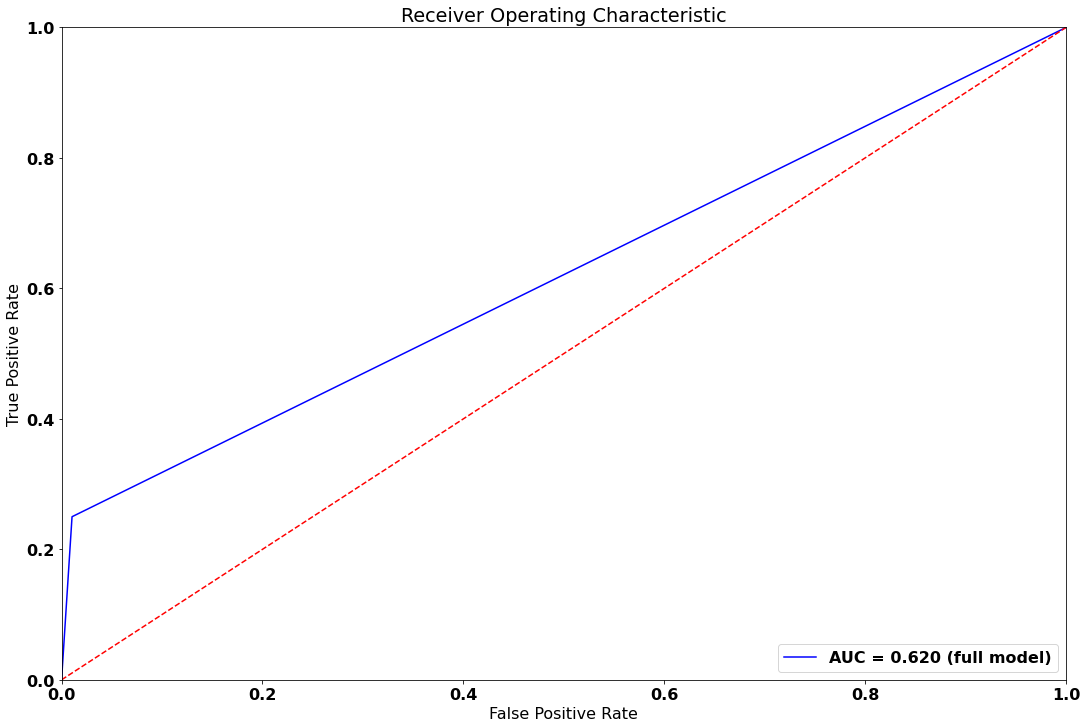

In [22]:
# compute ROC-AUC
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, predictions)
roc_auc1 = metrics.auc(fpr1, tpr1)

# plot
plt.figure(figsize=(18,12))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.3f (full model)' % roc_auc1)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

plt.show()